<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Archit Rungta
    
## <center> Tutorial
## <center> Imputing missing data with fancyimpute

Hi folks!

Often in real world applications of data analysis, we run into the problem of missing data. This can happen due to a multitude of reasons such as:
 - The data was compiled from different sources/times 
 - Corrupted during storage
 - Certain fields were optional
 - etc.
 

This notebook has the following sections:
 1. Introduction
 2. The Problem
 3. KNN Imputation
 4. Comparison And Application
 5. Summary
 6. Further Reading

In this tutorial, we look at the problem of missing data in data analytics. Then, we categorize the different types of missing data and briefly discuss the specific issue presented by each specific type. Finally, we look at various methods of handling data imputation and compare their accuracy on a real-world dataset with logistic regression. We also look at the validity of a commonly held assumption about imputation techniques. 

## <center> Introduction


Broadly, missing data is classified into 3 categories. 
 - Missing Completely At Random (MCAR)
 > Values in a data set are missing completely at random (MCAR) if the events that lead to any particular data-item being missing are independent both of observable variables and of unobservable parameters of interest, and occur entirely at random
 - Missing At Random (MAR)
 >Missing at random (MAR) occurs when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information
 - Missing Not At Random (MNAR)
 >Missing not at random (MNAR) (also known as nonignorable nonresponse) is data that is neither MAR nor MCAR
 
Data compilation from different sources is an example of MAR while data corruption is an example of MCAR. MNAR is not a problem we can fix with imputation because this is **non-ignorable non-response.** The only thing we can do about MNAR is to gather more information from different sources or ignore it all-together. As such we are not going to talk about MNAR anymore in this tutorial. 

All of the techniques that follow are applicable only for MCAR. However, in real world scenarios, MAR is more common. As such, we will treat MAR as MCAR only which gives a reasonably good approximation in practice.


## <center> The Problem


Let's start with a toy example, 

\begin{align}
\ y & = \sin(x) x\, \text{for $|x|<=6$}
\end{align}


In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

%matplotlib inline

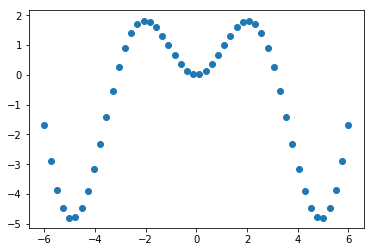

In [2]:
x = np.linspace(-6,6)
y = np.asarray([x1*np.sin(x1) for x1 in x])
plt.scatter(x,y)

Let's delete some points on random to get an MCAR dataset

In [3]:
missing_fraction = 0.3
indices = np.random.randint(1,len(x)-1, size=int((1-missing_fraction)*len(x)))
x_mcar = x[indices]
y_mcar = y[indices]


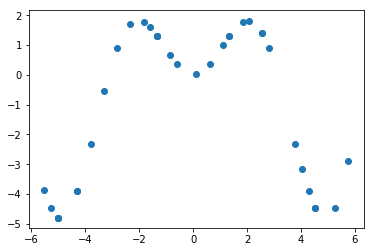

In [4]:
plt.scatter(x_mcar,y_mcar)

Throughout this tutorial, we will use MSE as an indicator of how good an imputation technique is when we have the original dataset and accuracy on predictions when we don't

In [5]:
from sklearn.metrics import mean_squared_error as mse

Let's try the easiest methods first:
 - Mean
 - Median

2.26262965947143

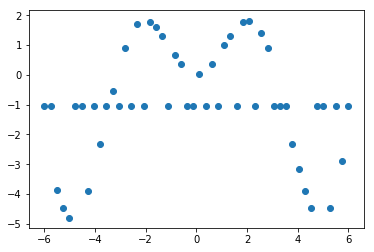

In [6]:
y_pred_mean = np.array(y)
for ind in list(set(np.linspace(0,len(x)-1))-set(indices)):
    y_pred_mean[int(ind)] = np.mean(y_mcar)
plt.scatter(x,y_pred_mean)
mse(y_pred_mean,y)

3.2995309240897033

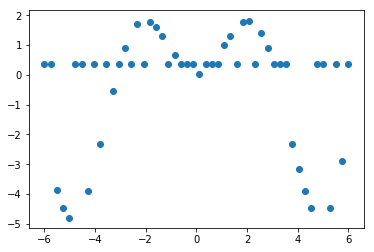

In [7]:
y_pred_median = np.array(y)
for ind in list(set(np.linspace(0,len(x)-1))-set(indices)):
    y_pred_median[int(ind)] = np.median(y_mcar)
plt.scatter(x,y_pred_median)
mse(y_pred_median,y)

Well, this seems like pretty awful. Let's see what fancyimpute has to offer. 
**Note: You need TensorFlow**

In [8]:
!pip install fancyimpute

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [9]:
import fancyimpute

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
y_pred_knn = np.concatenate((np.array(y).reshape(-1,1), np.array(x).reshape(-1,1)), axis=1)
for ind in indices:
    y_pred_knn[int(ind)] = [float("NaN"), y_pred_knn[int(ind)][1]]
y_pred_knn = fancyimpute.KNN(k=3).fit_transform(y_pred_knn)


Imputing row 1/50 with 0 missing, elapsed time: 0.004


In [11]:
y_pred_knn_2 = [x[0] for x in y_pred_knn]

0.11433938631068095

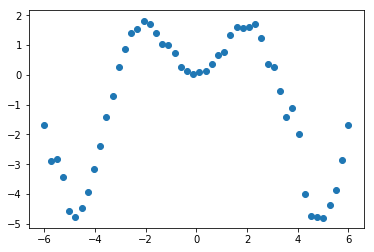

In [12]:
plt.scatter(x,y_pred_knn_2)
mse(y_pred_knn_2,y)

As we can see, fancyimpute has performed much better than mean or median methods on this toy dataset. 

Next up, we get some in-depth understanding of how the KNN algorithm for fancyimpute works and apply it to some real datasets. 


## <center> KNN Imputation


>In pattern recognition, the k-nearest neighbors algorithm is a non-parametric method used for classification and regression

The assumption behind using KNN for missing values is that a point value can be approximated by the values of the points that are closest to it, based on other variables.

The fancyimpute KNN algorithm works by calculating the k nearest neighbors which have the missing features available and then weights them based on Euclidean distance from the target row. The missing value is then calculated as a weighted mean from these neighboring rows.

Below is an implementation for k = 2. Because we know our data is sorted we can code this much more efficiently. However, this isn't a general implementation. We also ignore the possibility that both of the closest neighbors can be on the same side to reduce the complexity of the code.

In [13]:
y_cust = np.array(y)
for ind in indices:
    low1 = ind-1
    while low1 in indices:
        low1 = low1 - 1
    high1 = ind + 1
    while high1 in indices:
        high1 = high1 + 1
    d1 = 1/(ind - low1)
    d2 = 1/(high1 - ind)
    y_cust[ind] = (d1*y_cust[low1]+d2*y_cust[high1])/(d1+d2)

0.034650998762531186

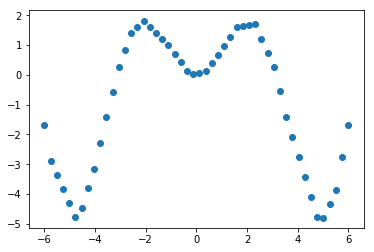

In [14]:
plt.scatter(x,y_cust)
mse(y_cust,y)

## <center> Comparison and Application


We will use the Pima Indians Diabetes database for our example use case. This is an example of a MAR dataset but we will treat it as MCAR to make the best out of what we have. You can download the data from - https://www.kaggle.com/kumargh/pimaindiansdiabetescsv

In [15]:
df  = pd.read_csv('pima-indians-diabetes.csv',header=None)

In [16]:
df.head()

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


 0. Number of times pregnant
 1. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
 2. Diastolic blood pressure (mm Hg)
 3. Triceps skin fold thickness (mm)
 4. 2-Hour serum insulin (mu U/ml)
 5. Body mass index (weight in kg/(height in m)^2)
 6. Diabetes pedigree function
 7. Age (years)
 8. Class variable (0 or 1)


Clearly, a person cannot have triceps sking fold thickness as 0 mm. This is a missing value and we need to replace 0 with NaN to let our algorithms know that it's a missing value.

By reading the descriptions we can be sure that columns 1,2,3,4,5,6 and 7 cannot have zero values. As such, we will mark 0s as missing. 

Also, imputing functions work better with scaled features so we will use MinMaxScaler to scale every feature between 0 to 1.

In [17]:
(df[[1,2,3,4,5,6,7]] == 0).sum()


1      5
2     35
3    227
4    374
5     11
6      0
7      0
dtype: int64

In [18]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(data=MinMaxScaler().fit_transform(df.values), columns=df.columns, index=df.index)
df[[1,2,3,4,5,6,7]] = df[[1,2,3,4,5,6,7]].replace(0,float('NaN'))

In [19]:
df.head()

,0,1,2,3,4,5,6,7,8
0,0.352941,0.743719,0.590164,0.353535,NaN,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,NaN,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,NaN,NaN,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,NaN,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1.0


fancyimpute offers many different forms of imputation methods, however, we are only comparing the four mentioned below. You can read about all of these at https://pypi.org/project/fancyimpute/

Now, we will compare Logistic Regression using four different imputation methods:
 - KNN
 - Mean
 - IterativeImputer
 - SoftImpute

We will first construct the dataframe for the bottom three because for KNN we need to find the optimum value of the hyperparameter. 

In [20]:
df_mean=pd.DataFrame(data=fancyimpute.SimpleFill().fit_transform(df.values), columns=df.columns, index=df.index)
df_iterative=pd.DataFrame(data=fancyimpute.IterativeImputer().fit_transform(df.values), columns=df.columns, index=df.index)
df_soft=pd.DataFrame(data=fancyimpute.SoftImpute().fit_transform(df.values), columns=df.columns, index=df.index)


[SoftImpute] Max Singular Value of X_init = 31.698472
[SoftImpute] Iter 1: observed MAE=0.017449 rank=9
[SoftImpute] Iter 2: observed MAE=0.017573 rank=9
[SoftImpute] Iter 3: observed MAE=0.017683 rank=9
[SoftImpute] Iter 4: observed MAE=0.017781 rank=9
[SoftImpute] Iter 5: observed MAE=0.017869 rank=9
[SoftImpute] Iter 6: observed MAE=0.017944 rank=9
[SoftImpute] Iter 7: observed MAE=0.018009 rank=9
[SoftImpute] Iter 8: observed MAE=0.018064 rank=9
[SoftImpute] Iter 9: observed MAE=0.018111 rank=9
[SoftImpute] Iter 10: observed MAE=0.018151 rank=9
[SoftImpute] Iter 11: observed MAE=0.018186 rank=9
[SoftImpute] Iter 12: observed MAE=0.018216 rank=9
[SoftImpute] Iter 13: observed MAE=0.018242 rank=9
[SoftImpute] Iter 14: observed MAE=0.018265 rank=9
[SoftImpute] Iter 15: observed MAE=0.018285 rank=9
[SoftImpute] Iter 16: observed MAE=0.018301 rank=9
[SoftImpute] Iter 17: observed MAE=0.018315 rank=9
[SoftImpute] Iter 18: observed MAE=0.018326 rank=9
[SoftImpute] Iter 19: observed MAE=0.

In [21]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
validation_split = 0.8
input_columns = [0,1,2,3,4,5,6,7]


In [22]:
logisticRegr.fit(df_mean[:int(len(df)*validation_split)][input_columns], df[:int(len(df)*validation_split)][8].values )
mean_score = logisticRegr.score(df_mean[int(len(df)*validation_split):][input_columns], df[int(len(df)*validation_split):][8].values )
mean_score

0.7597402597402597

In [23]:
logisticRegr = LogisticRegression()

logisticRegr.fit(df_iterative[:int(len(df)*validation_split)][input_columns], df[:int(len(df)*validation_split)][8].values )
iter_score = logisticRegr.score(df_iterative[int(len(df)*validation_split):][input_columns], df[int(len(df)*validation_split):][8].values )
iter_score

0.7727272727272727

In [24]:
logisticRegr = LogisticRegression()

logisticRegr.fit(df_soft[:int(len(df)*validation_split)][input_columns], df[:int(len(df)*validation_split)][8].values )
soft_score = logisticRegr.score(df_soft[int(len(df)*validation_split):][input_columns], df[int(len(df)*validation_split):][8].values )
soft_score

0.7727272727272727

In [25]:
results_knn = []

for k in range(2,30):
    df_knn=pd.DataFrame(data=fancyimpute.KNN(k=k).fit_transform(df.values), columns=df.columns, index=df.index)
    logisticRegr.fit(df_knn[:int(len(df)*validation_split)][input_columns], df[:int(len(df)*validation_split)][8].values )
    results_knn.append(logisticRegr.score(df_knn[int(len(df)*validation_split):][input_columns], df[int(len(df)*validation_split):][8].values ))


Imputing row 1/768 with 1 missing, elapsed time: 0.265
Imputing row 101/768 with 2 missing, elapsed time: 0.272
Imputing row 201/768 with 2 missing, elapsed time: 0.275
Imputing row 301/768 with 3 missing, elapsed time: 0.278
Imputing row 401/768 with 2 missing, elapsed time: 0.282
Imputing row 501/768 with 1 missing, elapsed time: 0.287
Imputing row 601/768 with 1 missing, elapsed time: 0.292
Imputing row 701/768 with 0 missing, elapsed time: 0.297
Imputing row 1/768 with 1 missing, elapsed time: 0.281
Imputing row 101/768 with 2 missing, elapsed time: 0.288
Imputing row 201/768 with 2 missing, elapsed time: 0.293
Imputing row 301/768 with 3 missing, elapsed time: 0.298
Imputing row 401/768 with 2 missing, elapsed time: 0.305
Imputing row 501/768 with 1 missing, elapsed time: 0.309
Imputing row 601/768 with 1 missing, elapsed time: 0.315
Imputing row 701/768 with 0 missing, elapsed time: 0.321
Imputing row 1/768 with 1 missing, elapsed time: 0.256
Imputing row 101/768 with 2 missing, 

Imputing row 1/768 with 1 missing, elapsed time: 0.265
Imputing row 101/768 with 2 missing, elapsed time: 0.270
Imputing row 201/768 with 2 missing, elapsed time: 0.274
Imputing row 301/768 with 3 missing, elapsed time: 0.278
Imputing row 401/768 with 2 missing, elapsed time: 0.282
Imputing row 501/768 with 1 missing, elapsed time: 0.286
Imputing row 601/768 with 1 missing, elapsed time: 0.290
Imputing row 701/768 with 0 missing, elapsed time: 0.294
Imputing row 1/768 with 1 missing, elapsed time: 0.267
Imputing row 101/768 with 2 missing, elapsed time: 0.272
Imputing row 201/768 with 2 missing, elapsed time: 0.278
Imputing row 301/768 with 3 missing, elapsed time: 0.284
Imputing row 401/768 with 2 missing, elapsed time: 0.288
Imputing row 501/768 with 1 missing, elapsed time: 0.292
Imputing row 601/768 with 1 missing, elapsed time: 0.299
Imputing row 701/768 with 0 missing, elapsed time: 0.304
Imputing row 1/768 with 1 missing, elapsed time: 0.268
Imputing row 101/768 with 2 missing, 

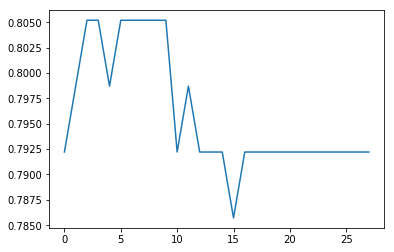

In [26]:
plt.plot(results_knn)


Summarising the results:
 - Mean Imputation - 75.97%
 - Iterative Imputer - 77.27%
 - Soft Imputer - 77.27%
 - KNN Imputation - 80.52%

It is often claimed that mean imputation is just as good as the fancier methods such as KNN when used in conjunction with more complicated models. To test it, we build a simple neural network and train it with mean imputed data and compare results with KNN imputed data. 

In [27]:
!pip install keras

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(10,activation='relu', input_dim=8))

model.add(Dense(10,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(df_mean[input_columns], df[8], batch_size=32, epochs=400, validation_split=0.2)

Train on 614 samples, validate on 154 samples
Epoch 1/400
614/614 [==============================] - 1s 900us/step - loss: 0.7004 - acc: 0.3941 - val_loss: 0.6877 - val_acc: 0.6039
Epoch 2/400
614/614 [==============================] - 0s 95us/step - loss: 0.6769 - acc: 0.7101 - val_loss: 0.6661 - val_acc: 0.6494
Epoch 3/400
614/614 [==============================] - 0s 101us/step - loss: 0.6599 - acc: 0.6612 - val_loss: 0.6540 - val_acc: 0.6429
Epoch 4/400
614/614 [==============================] - 0s 62us/step - loss: 0.6512 - acc: 0.6531 - val_loss: 0.6494 - val_acc: 0.6429
Epoch 5/400
614/614 [==============================] - 0s 83us/step - loss: 0.6459 - acc: 0.6531 - val_loss: 0.6456 - val_acc: 0.6429
Epoch 6/400
614/614 [==============================] - 0s 79us/step - loss: 0.6415 - acc: 0.6531 - val_loss: 0.6418 - val_acc: 0.6429
Epoch 7/400
614/614 [==============================] - 0s 57us/step - loss: 0.6368 - acc: 0.6547 - val_loss: 0.6370 - val_acc: 0.6429
Epoch 8/400
61

614/614 [==============================] - 0s 62us/step - loss: 0.4950 - acc: 0.7541 - val_loss: 0.4917 - val_acc: 0.7922
Epoch 62/400
614/614 [==============================] - 0s 71us/step - loss: 0.4950 - acc: 0.7492 - val_loss: 0.4886 - val_acc: 0.7792
Epoch 63/400
614/614 [==============================] - 0s 83us/step - loss: 0.4934 - acc: 0.7508 - val_loss: 0.4894 - val_acc: 0.7532
Epoch 64/400
614/614 [==============================] - 0s 113us/step - loss: 0.4932 - acc: 0.7622 - val_loss: 0.4880 - val_acc: 0.7532
Epoch 65/400
614/614 [==============================] - 0s 102us/step - loss: 0.4909 - acc: 0.7557 - val_loss: 0.4861 - val_acc: 0.7597
Epoch 66/400
614/614 [==============================] - 0s 102us/step - loss: 0.4908 - acc: 0.7541 - val_loss: 0.4855 - val_acc: 0.7597
Epoch 67/400
614/614 [==============================] - 0s 117us/step - loss: 0.4918 - acc: 0.7541 - val_loss: 0.4886 - val_acc: 0.7532
Epoch 68/400
614/614 [==============================] - 0s 122us

614/614 [==============================] - 0s 67us/step - loss: 0.4695 - acc: 0.7720 - val_loss: 0.4707 - val_acc: 0.7662
Epoch 122/400
614/614 [==============================] - 0s 101us/step - loss: 0.4711 - acc: 0.7638 - val_loss: 0.4696 - val_acc: 0.7597
Epoch 123/400
614/614 [==============================] - 0s 88us/step - loss: 0.4695 - acc: 0.7638 - val_loss: 0.4737 - val_acc: 0.7727
Epoch 124/400
614/614 [==============================] - 0s 125us/step - loss: 0.4693 - acc: 0.7638 - val_loss: 0.4874 - val_acc: 0.7468
Epoch 125/400
614/614 [==============================] - 0s 119us/step - loss: 0.4692 - acc: 0.7834 - val_loss: 0.4707 - val_acc: 0.7597
Epoch 126/400
614/614 [==============================] - 0s 218us/step - loss: 0.4674 - acc: 0.7704 - val_loss: 0.4863 - val_acc: 0.7532
Epoch 127/400
614/614 [==============================] - 0s 102us/step - loss: 0.4697 - acc: 0.7769 - val_loss: 0.4693 - val_acc: 0.7597
Epoch 128/400
614/614 [==============================] - 

Epoch 181/400
614/614 [==============================] - 0s 68us/step - loss: 0.4598 - acc: 0.7736 - val_loss: 0.4730 - val_acc: 0.7597
Epoch 182/400
614/614 [==============================] - 0s 88us/step - loss: 0.4612 - acc: 0.7752 - val_loss: 0.4695 - val_acc: 0.7532
Epoch 183/400
614/614 [==============================] - 0s 54us/step - loss: 0.4602 - acc: 0.7785 - val_loss: 0.4709 - val_acc: 0.7597
Epoch 184/400
614/614 [==============================] - 0s 115us/step - loss: 0.4622 - acc: 0.7720 - val_loss: 0.4699 - val_acc: 0.7597
Epoch 185/400
614/614 [==============================] - 0s 93us/step - loss: 0.4613 - acc: 0.7736 - val_loss: 0.4723 - val_acc: 0.7597
Epoch 186/400
614/614 [==============================] - 0s 63us/step - loss: 0.4606 - acc: 0.7801 - val_loss: 0.4722 - val_acc: 0.7597
Epoch 187/400
614/614 [==============================] - 0s 73us/step - loss: 0.4596 - acc: 0.7769 - val_loss: 0.4731 - val_acc: 0.7662
Epoch 188/400
614/614 [========================

614/614 [==============================] - 0s 58us/step - loss: 0.4582 - acc: 0.7655 - val_loss: 0.4675 - val_acc: 0.7597
Epoch 242/400
614/614 [==============================] - 0s 70us/step - loss: 0.4572 - acc: 0.7720 - val_loss: 0.4746 - val_acc: 0.7532
Epoch 243/400
614/614 [==============================] - 0s 63us/step - loss: 0.4566 - acc: 0.7769 - val_loss: 0.4701 - val_acc: 0.7662
Epoch 244/400
614/614 [==============================] - 0s 86us/step - loss: 0.4549 - acc: 0.7785 - val_loss: 0.4792 - val_acc: 0.7597
Epoch 245/400
614/614 [==============================] - 0s 89us/step - loss: 0.4595 - acc: 0.7720 - val_loss: 0.4702 - val_acc: 0.7727
Epoch 246/400
614/614 [==============================] - 0s 76us/step - loss: 0.4576 - acc: 0.7769 - val_loss: 0.4716 - val_acc: 0.7792
Epoch 247/400
614/614 [==============================] - 0s 89us/step - loss: 0.4571 - acc: 0.7769 - val_loss: 0.4673 - val_acc: 0.7597
Epoch 248/400
614/614 [==============================] - 0s 81

614/614 [==============================] - 0s 57us/step - loss: 0.4534 - acc: 0.7834 - val_loss: 0.4781 - val_acc: 0.7468
Epoch 302/400
614/614 [==============================] - 0s 75us/step - loss: 0.4550 - acc: 0.7834 - val_loss: 0.4759 - val_acc: 0.7532
Epoch 303/400
614/614 [==============================] - 0s 55us/step - loss: 0.4548 - acc: 0.7818 - val_loss: 0.4698 - val_acc: 0.7468
Epoch 304/400
614/614 [==============================] - 0s 84us/step - loss: 0.4546 - acc: 0.7801 - val_loss: 0.4701 - val_acc: 0.7468
Epoch 305/400
614/614 [==============================] - 0s 65us/step - loss: 0.4524 - acc: 0.7769 - val_loss: 0.4749 - val_acc: 0.7857
Epoch 306/400
614/614 [==============================] - 0s 70us/step - loss: 0.4535 - acc: 0.7752 - val_loss: 0.4692 - val_acc: 0.7468
Epoch 307/400
614/614 [==============================] - 0s 80us/step - loss: 0.4543 - acc: 0.7834 - val_loss: 0.4681 - val_acc: 0.7468
Epoch 308/400
614/614 [==============================] - 0s 84

614/614 [==============================] - 0s 49us/step - loss: 0.4521 - acc: 0.7752 - val_loss: 0.4712 - val_acc: 0.7468
Epoch 362/400
614/614 [==============================] - 0s 45us/step - loss: 0.4488 - acc: 0.7801 - val_loss: 0.4692 - val_acc: 0.7532
Epoch 363/400
614/614 [==============================] - 0s 52us/step - loss: 0.4502 - acc: 0.7834 - val_loss: 0.4714 - val_acc: 0.7468
Epoch 364/400
614/614 [==============================] - 0s 52us/step - loss: 0.4507 - acc: 0.7866 - val_loss: 0.4716 - val_acc: 0.7597
Epoch 365/400
614/614 [==============================] - 0s 63us/step - loss: 0.4507 - acc: 0.7834 - val_loss: 0.4774 - val_acc: 0.7597
Epoch 366/400
614/614 [==============================] - 0s 63us/step - loss: 0.4493 - acc: 0.7834 - val_loss: 0.4731 - val_acc: 0.7468
Epoch 367/400
614/614 [==============================] - 0s 54us/step - loss: 0.4472 - acc: 0.7883 - val_loss: 0.4734 - val_acc: 0.7468
Epoch 368/400
614/614 [==============================] - 0s 63

In [29]:
df_knn=pd.DataFrame(data=fancyimpute.KNN(k=8).fit_transform(df.values), columns=df.columns, index=df.index)
model = Sequential()
model.add(Dense(10,activation='relu', input_dim=8))

model.add(Dense(10,activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(df_knn[input_columns], df[8], batch_size=32, epochs=400, validation_split=0.2)

Imputing row 1/768 with 1 missing, elapsed time: 0.252
Imputing row 101/768 with 2 missing, elapsed time: 0.256
Imputing row 201/768 with 2 missing, elapsed time: 0.259
Imputing row 301/768 with 3 missing, elapsed time: 0.261
Imputing row 401/768 with 2 missing, elapsed time: 0.264
Imputing row 501/768 with 1 missing, elapsed time: 0.267
Imputing row 601/768 with 1 missing, elapsed time: 0.275
Imputing row 701/768 with 0 missing, elapsed time: 0.283
Train on 614 samples, validate on 154 samples
Epoch 1/400
614/614 [==============================] - 0s 650us/step - loss: 0.7430 - acc: 0.3469 - val_loss: 0.7083 - val_acc: 0.3636
Epoch 2/400
614/614 [==============================] - 0s 45us/step - loss: 0.6932 - acc: 0.4739 - val_loss: 0.6788 - val_acc: 0.6623
Epoch 3/400
614/614 [==============================] - 0s 73us/step - loss: 0.6685 - acc: 0.6710 - val_loss: 0.6619 - val_acc: 0.6688
Epoch 4/400
614/614 [==============================] - 0s 52us/step - loss: 0.6541 - acc: 0.6596 

614/614 [==============================] - 0s 72us/step - loss: 0.4727 - acc: 0.7704 - val_loss: 0.4723 - val_acc: 0.7792
Epoch 59/400
614/614 [==============================] - 0s 58us/step - loss: 0.4705 - acc: 0.7769 - val_loss: 0.4683 - val_acc: 0.7857
Epoch 60/400
614/614 [==============================] - 0s 54us/step - loss: 0.4691 - acc: 0.7752 - val_loss: 0.4730 - val_acc: 0.7662
Epoch 61/400
614/614 [==============================] - 0s 70us/step - loss: 0.4696 - acc: 0.7785 - val_loss: 0.4665 - val_acc: 0.7857
Epoch 62/400
614/614 [==============================] - 0s 62us/step - loss: 0.4691 - acc: 0.7720 - val_loss: 0.4647 - val_acc: 0.7922
Epoch 63/400
614/614 [==============================] - 0s 78us/step - loss: 0.4669 - acc: 0.7752 - val_loss: 0.4671 - val_acc: 0.7792
Epoch 64/400
614/614 [==============================] - 0s 60us/step - loss: 0.4667 - acc: 0.7769 - val_loss: 0.4632 - val_acc: 0.7987
Epoch 65/400
614/614 [==============================] - 0s 65us/step

614/614 [==============================] - 0s 47us/step - loss: 0.4391 - acc: 0.7915 - val_loss: 0.4346 - val_acc: 0.8052
Epoch 119/400
614/614 [==============================] - 0s 55us/step - loss: 0.4380 - acc: 0.7850 - val_loss: 0.4367 - val_acc: 0.7987
Epoch 120/400
614/614 [==============================] - 0s 58us/step - loss: 0.4391 - acc: 0.7834 - val_loss: 0.4329 - val_acc: 0.8052
Epoch 121/400
614/614 [==============================] - 0s 101us/step - loss: 0.4387 - acc: 0.7801 - val_loss: 0.4331 - val_acc: 0.8052
Epoch 122/400
614/614 [==============================] - 0s 70us/step - loss: 0.4372 - acc: 0.7883 - val_loss: 0.4329 - val_acc: 0.7987
Epoch 123/400
614/614 [==============================] - 0s 78us/step - loss: 0.4378 - acc: 0.7850 - val_loss: 0.4351 - val_acc: 0.8052
Epoch 124/400
614/614 [==============================] - 0s 86us/step - loss: 0.4382 - acc: 0.7834 - val_loss: 0.4329 - val_acc: 0.7987
Epoch 125/400
614/614 [==============================] - 0s 8

614/614 [==============================] - 0s 62us/step - loss: 0.4232 - acc: 0.7883 - val_loss: 0.4192 - val_acc: 0.7922
Epoch 179/400
614/614 [==============================] - 0s 55us/step - loss: 0.4224 - acc: 0.8013 - val_loss: 0.4229 - val_acc: 0.7987
Epoch 180/400
614/614 [==============================] - 0s 50us/step - loss: 0.4220 - acc: 0.7899 - val_loss: 0.4228 - val_acc: 0.8052
Epoch 181/400
614/614 [==============================] - 0s 52us/step - loss: 0.4225 - acc: 0.8029 - val_loss: 0.4206 - val_acc: 0.8052
Epoch 182/400
614/614 [==============================] - 0s 67us/step - loss: 0.4214 - acc: 0.7964 - val_loss: 0.4192 - val_acc: 0.7922
Epoch 183/400
614/614 [==============================] - 0s 78us/step - loss: 0.4220 - acc: 0.7964 - val_loss: 0.4172 - val_acc: 0.7922
Epoch 184/400
614/614 [==============================] - 0s 73us/step - loss: 0.4211 - acc: 0.8013 - val_loss: 0.4173 - val_acc: 0.8117
Epoch 185/400
614/614 [==============================] - 0s 70

614/614 [==============================] - 0s 49us/step - loss: 0.4086 - acc: 0.7980 - val_loss: 0.4043 - val_acc: 0.8052
Epoch 239/400
614/614 [==============================] - 0s 50us/step - loss: 0.4094 - acc: 0.7932 - val_loss: 0.4053 - val_acc: 0.8052
Epoch 240/400
614/614 [==============================] - 0s 54us/step - loss: 0.4088 - acc: 0.8013 - val_loss: 0.4037 - val_acc: 0.7987
Epoch 241/400
614/614 [==============================] - 0s 55us/step - loss: 0.4096 - acc: 0.8013 - val_loss: 0.4076 - val_acc: 0.8052
Epoch 242/400
614/614 [==============================] - 0s 54us/step - loss: 0.4080 - acc: 0.8013 - val_loss: 0.4044 - val_acc: 0.8052
Epoch 243/400
614/614 [==============================] - 0s 49us/step - loss: 0.4070 - acc: 0.7948 - val_loss: 0.4145 - val_acc: 0.8182
Epoch 244/400
614/614 [==============================] - 0s 45us/step - loss: 0.4091 - acc: 0.8094 - val_loss: 0.4073 - val_acc: 0.8052
Epoch 245/400
614/614 [==============================] - 0s 49

614/614 [==============================] - 0s 42us/step - loss: 0.3949 - acc: 0.8062 - val_loss: 0.3871 - val_acc: 0.8377
Epoch 299/400
614/614 [==============================] - 0s 42us/step - loss: 0.3965 - acc: 0.8094 - val_loss: 0.3869 - val_acc: 0.8442
Epoch 300/400
614/614 [==============================] - 0s 52us/step - loss: 0.3963 - acc: 0.8029 - val_loss: 0.3882 - val_acc: 0.8442
Epoch 301/400
614/614 [==============================] - 0s 57us/step - loss: 0.3961 - acc: 0.8111 - val_loss: 0.3884 - val_acc: 0.8442
Epoch 302/400
614/614 [==============================] - 0s 60us/step - loss: 0.3956 - acc: 0.8046 - val_loss: 0.3885 - val_acc: 0.8442
Epoch 303/400
614/614 [==============================] - 0s 57us/step - loss: 0.3951 - acc: 0.8078 - val_loss: 0.3923 - val_acc: 0.8247
Epoch 304/400
614/614 [==============================] - 0s 45us/step - loss: 0.3965 - acc: 0.8029 - val_loss: 0.3855 - val_acc: 0.8442
Epoch 305/400
614/614 [==============================] - 0s 49

614/614 [==============================] - 0s 47us/step - loss: 0.3880 - acc: 0.8078 - val_loss: 0.3802 - val_acc: 0.8636
Epoch 359/400
614/614 [==============================] - 0s 49us/step - loss: 0.3878 - acc: 0.8143 - val_loss: 0.3905 - val_acc: 0.8117
Epoch 360/400
614/614 [==============================] - 0s 67us/step - loss: 0.3892 - acc: 0.8046 - val_loss: 0.3812 - val_acc: 0.8506
Epoch 361/400
614/614 [==============================] - 0s 54us/step - loss: 0.3885 - acc: 0.8111 - val_loss: 0.3883 - val_acc: 0.8247
Epoch 362/400
614/614 [==============================] - 0s 45us/step - loss: 0.3863 - acc: 0.8078 - val_loss: 0.3794 - val_acc: 0.8636
Epoch 363/400
614/614 [==============================] - 0s 55us/step - loss: 0.3876 - acc: 0.8062 - val_loss: 0.3799 - val_acc: 0.8636
Epoch 364/400
614/614 [==============================] - 0s 52us/step - loss: 0.3872 - acc: 0.8078 - val_loss: 0.3853 - val_acc: 0.8377
Epoch 365/400
614/614 [==============================] - 0s 63

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                90        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


As evident from this highly unscientific test, the common wisdom that mean imputation is just as good is not necessarily true. Even with this overkill of a model, KNN imputed data performs significantly better than mean imputed data(0.8701 - epoch 396 vs 0.7987 - epoch 324 in this run)

## <center> Summary


Missing data is broadly classified into three categories: MCAR, MAR and MNAR. We show the abysmal performance of mean imputation and median imputation with a toy example. Next, we create an intuitive understanding of KNN imputation and write sample code for its implementation. 

Finally, we apply the techniques to Pima Indian Diabetes set and use four different imputation strategies. We show the superiority of KNN imputation technique over other imputation strategies for both logistic regression and neural networks, discrediting a common belief about imputation techniques.

## <center> Further Reading


 - https://pypi.org/project/fancyimpute/
 - https://github.com/iskandr/fancyimpute/tree/master/fancyimpute
 - https://github.com/iskandr/knnimpute/blob/master/knnimpute/few_observed_entries.py
 - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4959387/